In [1]:
import time
import numpy as np
import sympy as sm
import scipy as sp
import pandas as pd
from ggplot import *
from itertools import product
from matplotlib.axes._axes import _log as matplotlib_axes_logger

matplotlib_axes_logger.setLevel('ERROR')

In [2]:
elementsData = dict()
elementsChars = ['H', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'mu', 'sigma', 'epsil']
elements = ['AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2', 'Al', 'Ga', 'AlN', 'GaN']

dataFile = open('data.txt', 'r')
lines = dataFile.readlines()
for line in lines:
    dataArr = line.rstrip().split(';')
    elementsData[dataArr[0]] = dict()
    for i in range(0, len(dataArr) - 1):
        elementsData[dataArr[0]][elementsChars[i]] = float(dataArr[i + 1])

In [3]:
R = 8.314  # Дж/(кмоль⋅К) - универсальная газовая постоянная
P_a = 100000  # Па – полное давление

In [4]:
"""
d - коэффициент диффузии (м2/сек)
compIndex - название элемента
temperature - температура
pressure - полное давление в системе (P^g_i - P^e_i)
"""
def d(compIndex, temperature, pressure):
    numerator = 2.628 * 10 ** (-2) * temperature ** (3 / 2)

    dataForIndex = elementsData[compIndex]
    dataForN2 = elementsData['N2']

    sigma = (dataForIndex['sigma'] + dataForN2['sigma']) / 2
    epsil = (dataForIndex['epsil'] * dataForN2['epsil']) ** (1 / 2)
    mu = (2 * dataForIndex['mu'] * dataForN2['mu']) / (dataForIndex['mu'] + dataForN2['mu'])
    omega = 1.074 * (temperature / epsil) ** (-0.1604)

    return numerator / (pressure * sigma * omega * mu ** (1 / 2))

"""
phi нужно для расчета энергии Гиббса (G)
compIndex - название элемента
temperature - температура
"""
def phi(compIndex, temperature):
    dataForIndex = elementsData[compIndex]

    x = temperature / 10 ** 4
    return dataForIndex['f1'] + \
           dataForIndex['f2'] * np.log(x) + \
           dataForIndex['f3'] / x ** 2 + \
           dataForIndex['f4'] / x + \
           dataForIndex['f5'] * x + \
           dataForIndex['f6'] * x ** 2 + \
           dataForIndex['f7'] * x ** 3
"""
g - Энергия Гиббса
compIndex - название элемента
temperature - температура
"""
def g(compIndex, temperature):
    dataForIndex = elementsData[compIndex]
    return dataForIndex['H'] - phi(compIndex, temperature) * temperature


In [5]:
# Коэффициенты равновесия для первого задания
def k1(temperature):
    g1Diff = 2 * g('Al', temperature) + 2 * g('HCl', temperature) - 2 * g('AlCl', temperature) - g('H2', temperature)
    return np.exp(-g1Diff / (R * temperature)) / P_a

def k2(temperature):
    g2Diff = g('Al', temperature) + 2 * g('HCl', temperature) - g('AlCl2', temperature) - g('H2', temperature)
    return np.exp(-g2Diff / (R * temperature))

def k3(temperature):
    g3Diff = 2 * g('Al', temperature) - 2 * g('AlCl3', temperature) - 3 * g('H2', temperature) + 6 * g('HCl', temperature)
    return np.exp(-g3Diff / (R * temperature)) * P_a

# Коэффициенты равновесия для второго задания
def k4(temperature):
    g4Diff = 2 * g('Ga', temperature) + 2 * g('HCl', temperature) - 2 * g('GaCl', temperature) - g('H2', temperature)
    return np.exp(-g4Diff / (R * temperature)) / P_a

def k5(temperature):
    g5Diff = g('GaCl2', temperature) + g('H2', temperature) - 2 * g('HCl', temperature) - g('Ga', temperature)
    return np.exp(g5Diff / (R * temperature))

def k6(temperature):
    g6Diff = 2 * g('GaCl3', temperature) + 3 * g('H2', temperature) - 6 * g('HCl', temperature) - 2 * g('Ga', temperature)
    return np.exp(g6Diff / (R * temperature)) * P_a

# Коэффициенты равновесия для третьего задания
def k9(temperature):
    g9Diff = g('AlCl3', temperature) + g('NH3', temperature) - g('AlN', temperature) - 3 * g('HCl', temperature)
    return np.exp(-g9Diff / (R * temperature)) / P_a

def k10(temperature):
    g10Diff = g('GaCl', temperature) + g('NH3', temperature) - g('HCl', temperature) - g('H2', temperature) - g('GaN', temperature)
    return np.exp(-g10Diff / (R * temperature))

**Метод Ньютона**

В качестве численного метода для решения СНАУ был выбран бызовый метод Ньютона без модификаций, которому на вход подается начальное приближение (способы выбора описаны в решении задания), сама система и набор неизвестных (последние два получены с помощью библиотеки sympy - библиотеки для символьных вычислений). Изначально получаем якобиан нашей системы с помощью уже упомянутой библиотеки. Далее на каждом шаге мы находим <чо находим?> и <чот прибавляем>, пока длина найденного вектора больше заданной точности, которую мы указали, или пока мы не упремся в лимит шагов (это сделано, чтобы не уйти в бесконечный цикл при отсутствии решения). Как только мы нашли решение с нужной точностью или уперлись в лимит шагов, мы возвращаем результат.

In [6]:
def newton_method(initX, system, variables):
    start_time = time.time()

    jacobian = sm.lambdify(variables, system.jacobian(variables))
    system = sm.lambdify(variables, system)
    
    x = initX
    eps = 1e-9
    LIMIT = 1e8
    delta = [1]
    steps = 0
    while np.linalg.norm(delta) > eps and steps < LIMIT:
        delta = sp.linalg.lu_solve(sp.linalg.lu_factor(jacobian(*x)), -system(*x))
        x = delta.flatten() + x
        steps += 1
    print("--- %s seconds ---" % (time.time() - start_time))
    print("--- %d steps ---\n" % steps)
    return x

# Задание №1

**Система:**


(P<sup>e</sup><sub>HCl</sub>)<sup>2</sup> - K<sub>1</sub> (P<sup>e</sup><sub>AlCl</sub>)<sup>2</sup>P<sup>e</sup><sub>H2</sub> = 0

(P<sup>e</sup><sub>HCl</sub>)<sup>2</sup> - K<sub>2</sub> (P<sup>e</sup><sub>AlCl2</sub>)<sup>2</sup>P<sup>e</sup><sub>H2</sub> = 0

(P<sup>e</sup><sub>HCl</sub>)<sup>6</sup> - K<sub>3</sub> (P<sup>e</sup><sub>AlCl3</sub>)<sup>2</sup>(P<sup>e</sup><sub>H2</sub>)<sup>3</sup> = 0


D<sub>HCl</sub>(P<sup>g</sup><sub>HCl</sub> - P<sup>e</sup><sub>HCl</sub>) + 2D<sub>H2</sub>(P<sup>g</sup><sub>H2</sub> - P<sup>e</sup><sub>H2</sub>) = 0

D<sub>AlCl</sub>(P<sup>g</sup><sub>AlCl</sub> - P<sup>e</sup><sub>AlCl</sub>) + 2D<sub>AlCl2</sub>(P<sup>g</sup><sub>AlCl2</sub> - P<sup>e</sup><sub>AlCl2</sub>) + 3D<sub>AlCl3</sub>(P<sup>g</sup><sub>AlCl3</sub> - P<sup>e</sup><sub>AlCl3</sub>) + D<sub>HCl</sub>(P<sup>g</sup><sub>HCl</sub> - P<sup>e</sup><sub>HCl</sub>) = 0


На каждом шаге для температур $T = 350\dots650℃$ с шагом $dT = 10℃$ производится решение данной СНУ, 

Такое решение даёт требуемые термодинамические давления, а с помощью формулы

$G_i = D_i \cdot (P^g_{i} - P^e_{i}) / RT\delta$

находятся межфазные потоки активных компонент. Далее по формуле

$ V^e_{Al} = (G_{AlCl} + G_{AlCl2} + G_{AlCl3}) (\mu_{Al} / \rho_{Al}) * 10^9$

находится скорость испарения алюминиевого источника.

In [7]:
"""
Парциальные давления компонент вне диффузионного пограничного слоя (Па) из условия заданий №1 и №2
"""
pg = { 'GaCl' : 0, 'GaCl2' : 0, 'GaCl3' : 0, 
       'AlCl' : 0, 'AlCl2' : 0, 'AlCl3' : 0, 
       'H2' : 0, 'N2' : 90000.0, 'HCl' : 10000.0 
     }

def system1(T):
    p_e_AlCl, p_e_AlCl2, p_e_AlCl3, p_e_HCl, p_e_H2 = sm.symbols('p_e_AlCl, p_e_AlCl2, p_e_AlCl3, p_e_HCl, p_e_H2')
    p = pg['N2'] + pg['HCl']
    d_HCl = d('HCl', T, p)
    d_H2 = d('H2', T, p)
    d_AlCl = d('AlCl', T, p)
    d_AlCl2 = d('AlCl2', T, p)
    d_AlCl3 = d('AlCl3', T, p)
    equations = []
    equations.append(p_e_HCl ** 2 - k1(T) * p_e_AlCl ** 2 * p_e_H2)
    equations.append(p_e_HCl ** 2 - k2(T) * p_e_AlCl2 * p_e_H2)
    equations.append(p_e_HCl ** 6 - k3(T) * p_e_AlCl3 ** 2 * p_e_H2 ** 3)
    equations.append(d_HCl * (pg['HCl'] - p_e_HCl) + 2 * p_e_H2 * (pg['H2'] - p_e_H2))
    equations.append(d_AlCl * (pg['AlCl'] - p_e_AlCl) + 
                     2 * d_AlCl2 * (pg['AlCl2'] - p_e_AlCl2) +
                     3 * d_AlCl3 * (pg['AlCl3'] - p_e_AlCl3)  +
                     d_HCl * (pg['HCl'] - p_e_HCl))
    system = sm.Matrix(equations)
    return system, (p_e_AlCl, p_e_AlCl2, p_e_AlCl3, p_e_HCl, p_e_H2)

**Решение задачи о конверсии хлороводорода (HCl) в хлориды алюминия (AlCl)**

Перебираем температуры в промежутке, указанном в задании (350-650 градусов по Цельсию), предварительно переводя их в градусы по Кельвину (+ 273). Для каждого значение температуры составляем систему и решаем её выше описанным методом. Получив значение термодинамических давлений, мы высчитываем межфазные потоки (G) на поверхности жидкого галлия для интересующих нас элементов, а затем и скорость испарения источника по формуле представленной в задании. Значения всех констант взяты из условия. В качестве начального приближения на первом шаге мы берем набор состоящий из элементов равномерного распредления от 0 до 1 необходимой длинны, а на последующих итерациях в качестве начального приближения используем сошедшееся решение системы прошлого шага.

In [8]:
temperatures = np.linspace(350, 650, 30) + 273
delta = 0.01
p = pg['HCl'] + pg['N2']
data_for_temperature = pd.DataFrame(columns=['T_', 'V_Al', 'G_AlCl', 'G_AlCl2', 'G_AlCl3'])
targets = ['AlCl', 'AlCl2', 'AlCl3']
initX = np.random.uniform(0.1, 1., 5).tolist()
for k, T in (enumerate(temperatures)):
    system, variables = system1(T)
    solution = newton_method(initX, system, variables)
    initX = solution
    # G for elements
    G = {}
    pe = dict(zip(map(str, variables), solution))
    for gasIndex in targets:
        G[gasIndex] = d(gasIndex, T, p) * (pg[gasIndex] - pe['p_e_' + gasIndex]) / (8314 * T * delta)
    density_Al = 2690
    mu_Al = elementsData['Al']['mu']
    V_Al = (G['AlCl'] + G['AlCl2'] + G['AlCl3']) * (mu_Al / density_Al) * 1e9
    data_for_temperature.loc[k] = {
        'T_': T,
        'V_Al': V_Al,
        'G_AlCl': G['AlCl'],
        'G_AlCl2': G['AlCl2'],
        'G_AlCl3': G['AlCl3'],
    }

--- 0.04698014259338379 seconds ---
--- 64 steps ---

--- 0.030813932418823242 seconds ---
--- 8 steps ---

--- 0.0316159725189209 seconds ---
--- 8 steps ---

--- 0.03322911262512207 seconds ---
--- 8 steps ---

--- 0.031343936920166016 seconds ---
--- 7 steps ---

--- 0.03133511543273926 seconds ---
--- 7 steps ---

--- 0.03234291076660156 seconds ---
--- 7 steps ---

--- 0.03457212448120117 seconds ---
--- 7 steps ---

--- 0.03192400932312012 seconds ---
--- 7 steps ---

--- 0.0317690372467041 seconds ---
--- 7 steps ---

--- 0.032373905181884766 seconds ---
--- 7 steps ---

--- 0.031646013259887695 seconds ---
--- 7 steps ---

--- 0.03249073028564453 seconds ---
--- 7 steps ---

--- 0.03377890586853027 seconds ---
--- 7 steps ---

--- 0.03209877014160156 seconds ---
--- 7 steps ---

--- 0.03145790100097656 seconds ---
--- 7 steps ---

--- 0.031052112579345703 seconds ---
--- 7 steps ---

--- 0.03539299964904785 seconds ---
--- 7 steps ---

--- 0.032553911209106445 seconds ---
--- 7

Собираем все необходимые данные в таблицу. Как нас просили в задании, берем значение обратное температуре в качестве координаты по X и линейный логарифм искомой величины по Y.

In [9]:
data_for_temperature['invT'] = 1 / data_for_temperature.T_
data_for_temperature['G_AlCl_log'] = np.log(np.abs(data_for_temperature.G_AlCl))
data_for_temperature['G_AlCl2_log'] = np.log(np.abs(data_for_temperature.G_AlCl2))
data_for_temperature['G_AlCl3_log'] = np.log(np.abs(data_for_temperature.G_AlCl3))
data_for_temperature['V_Al_log'] = np.log(np.abs(data_for_temperature.V_Al))

graph_data_comps = pd.melt(data_for_temperature[['invT', 'G_AlCl_log', 
                                      'G_AlCl2_log', 'G_AlCl3_log']], id_vars=['invT'])
graph_data_speed = pd.melt(data_for_temperature[['invT', 'V_Al_log']], id_vars=['invT'])

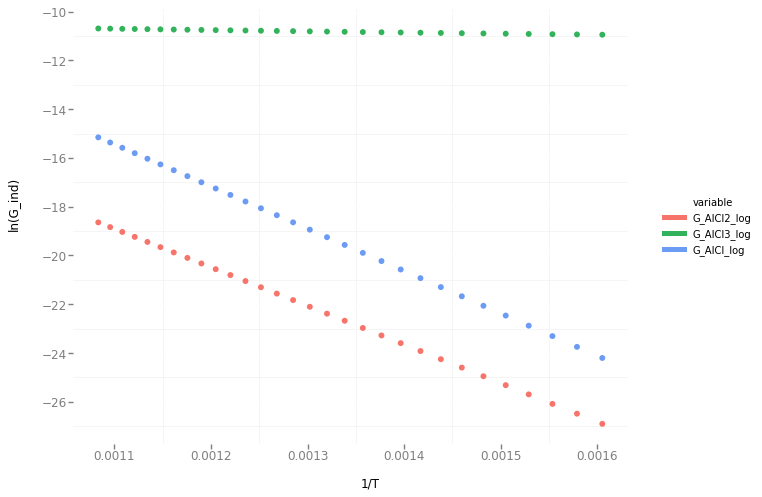

<ggplot: (316317301)>

In [10]:
(ggplot(aes(x = 'invT', y = 'value', color='variable'), graph_data_comps) + 
    geom_point(size=35) + 
    ylab('ln(G_ind)') + 
    xlab('1/T') + 
    theme_bw()
)

На графике выше представлены диаграммы Аррениуса для G<sub>AlCl</sub>, G<sub>AlCl2</sub>, G<sub>AlCl3</sub>

Из этого можно делать вывод, что преобладающим Al-содержащим компонентом является AlCl<sub>3</sub>.

Также установим зависимость скорости испарения источника алюминия V<sup>e</sup><sub>Al</sub> в зависимости от $1/T$.

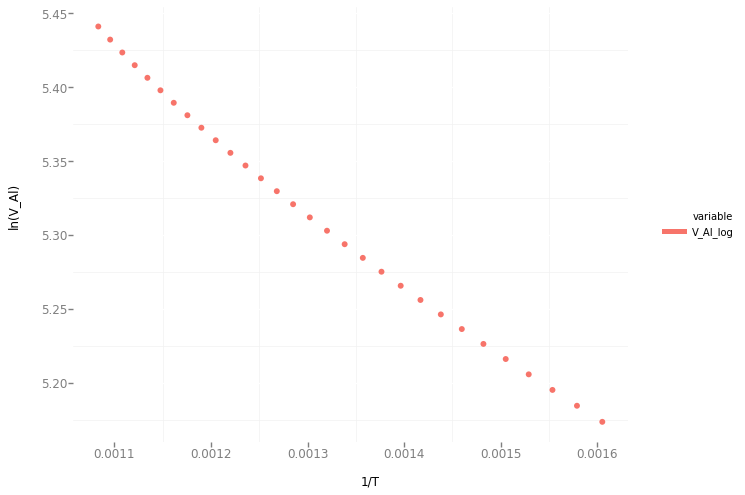

<ggplot: (302220421)>

In [11]:
(ggplot(aes(x = 'invT', y = 'value', color='variable'), graph_data_speed) + 
    geom_point(size=35) + 
    ylab('ln(V_Al)') + 
    xlab('1/T') + 
    theme_bw()
)

# Задание №2


**Система:**


(P<sup>e</sup><sub>HCl</sub>)<sup>2</sup> - K<sub>4</sub> (P<sup>e</sup><sub>GaCl</sub>)<sup>2</sup>P<sup>e</sup><sub>H2</sub> = 0

(P<sup>e</sup><sub>HCl</sub>)<sup>2</sup> - K<sub>5</sub> P<sup>e</sup><sub>GaCl2</sub>P<sup>e</sup><sub>H2</sub> = 0

(P<sup>e</sup><sub>HCl</sub>)<sup>6</sup> - K<sub>6</sub> (P<sup>e</sup><sub>GaCl3</sub>)<sup>2</sup>(P<sup>e</sup><sub>H2</sub>)<sup>3</sup> = 0


D<sub>HCl</sub>(P<sup>g</sup><sub>HCl</sub> - P<sup>e</sup><sub>HCl</sub>) + 2D<sub>H2</sub>(P<sup>g</sup><sub>H2</sub> - P<sup>e</sup><sub>H2</sub>) = 0

D<sub>GaCl</sub>(P<sup>g</sup><sub>GaCl</sub> - P<sup>e</sup><sub>GaCl</sub>) + 2D<sub>GaCl2</sub>(P<sup>g</sup><sub>GaCl2</sub> - P<sup>e</sup><sub>GaCl2</sub>) + 3D<sub>GaCl3</sub>(P<sup>g</sup><sub>GaCl3</sub> - P<sup>e</sup><sub>GaCl3</sub>) + D<sub>HCl</sub>(P<sup>g</sup><sub>HCl</sub> - P<sup>e</sup><sub>HCl</sub>) = 0

На каждом шаге для температур $T = 350\dots650℃$ с шагом $dT = 10℃$ производится решение данной СНУ, 

Такое решение даёт требуемые термодинамические давления, а с помощью формулы

$G_i = D_i \cdot (P^g_{i} - P^e_{i}) / RT\delta$

находятся межфазные потоки активных компонент. Далее по формуле

$ V^e_{Ga} = (G_{GaCl} + G_{GaCl_2} + G_{GaCl_3}) (\mu_{Ga} / \rho_{Ga}) * 10^9$

находится скорость испарения источника галлия.

In [12]:
def system2(T):
    p_e_GaCl, p_e_GaCl2, p_e_GaCl3, p_e_HCl, p_e_H2 = sm.symbols('p_e_GaCl, p_e_GaCl2, p_e_GaCl3, p_e_HCl, p_e_H2')
    p = pg['N2'] + pg['HCl']
    d_HCl = d('HCl', T, p)
    d_H2 = d('H2', T, p)
    d_GaCl = d('GaCl', T, p)
    d_GaCl2 = d('GaCl2', T, p)
    d_GaCl3 = d('GaCl3', T, p)
    equations = []
    equations.append(p_e_HCl ** 2 - k4(T) * p_e_GaCl ** 2 * p_e_H2)
    equations.append(p_e_HCl ** 2 - k5(T) * p_e_GaCl2 * p_e_H2)
    equations.append(p_e_HCl ** 6 - k6(T) * p_e_GaCl3 ** 2 * p_e_H2 ** 3)
    equations.append(d_HCl * (pg['HCl'] - p_e_HCl) + 2 * d_H2 * (pg['H2'] - p_e_H2))
    equations.append(d_GaCl  * (pg['GaCl'] - p_e_GaCl)  + 
                     2 * d_GaCl2 * (pg['GaCl2'] - p_e_GaCl2) + 
                     3 * d_GaCl3 * (pg['GaCl3'] - p_e_GaCl3) + 
                     d_HCl * (pg['HCl'] - p_e_HCl))
    system = sm.Matrix(equations)
    return system, (p_e_GaCl, p_e_GaCl2, p_e_GaCl3, p_e_HCl, p_e_H2)

**Решение задачи о конверсии хлороводорода (HCl) в хлориды галия (GaCl)**

Перебираем температуры в промежутке, указанном в задании (650-950 градусов по Цельсию), предварительно переводя их в градусы по Кельвину (+ 273). Для каждого значение температуры составляем систему и решаем её выше описанным методом. Получив значение термодинамических давлений, мы высчитываем межфазные потоки (G) на поверхности жидкого галлия для интересующих нас элементов, а затем и скорость испарения источника по формуле представленной в задании. Значения всех констант взяты из условия. В качестве начального приближения на первом шаге мы берем набор состоящий из элементов равномерного распредления от 0 до 1 необходимой длинны, а на последующих итерациях в качестве начального приближения используем сошедшееся решение системы прошлого шага.

In [13]:
data_for_temperature = pd.DataFrame(columns=['T_', 'V_Ga', 'G_GaCl', 'G_GaCl2', 'G_GaCl3'])
temperatures = np.linspace(650, 950, 30) + 273
targets = ['GaCl', 'GaCl2', 'GaCl3']
initX = np.random.uniform(0.1, 1., 5).tolist()
for k, T in (enumerate(temperatures)):
    system, variables = system2(T)
    solution = newton_method(initX, system, variables)
    initX = solution
    # G for elements
    G = {}
    pe = dict(zip(map(str, variables), solution))
    for gasIndex in targets:
        G[gasIndex] = d(gasIndex, T, p) * (pg[gasIndex] - pe['p_e_' + gasIndex]) / (8314 * T * delta)
    density_Ga = 5900.
    mu_Ga = elementsData['Ga']['mu']
    V_Ga = (G['GaCl'] + G['GaCl2'] + G['GaCl3']) * (mu_Ga / density_Ga) * 1e9
    data_for_temperature.loc[k] = {
        'T_': T,
        'V_Ga': V_Ga,
        'G_GaCl': G['GaCl'],
        'G_GaCl2': G['GaCl2'],
        'G_GaCl3': G['GaCl3']
    }

--- 0.03791308403015137 seconds ---
--- 19 steps ---

--- 0.03223705291748047 seconds ---
--- 6 steps ---

--- 0.031545162200927734 seconds ---
--- 6 steps ---

--- 0.031693220138549805 seconds ---
--- 6 steps ---

--- 0.03178882598876953 seconds ---
--- 6 steps ---

--- 0.031388044357299805 seconds ---
--- 6 steps ---

--- 0.03205990791320801 seconds ---
--- 6 steps ---

--- 0.035410165786743164 seconds ---
--- 6 steps ---

--- 0.03200578689575195 seconds ---
--- 6 steps ---

--- 0.032994985580444336 seconds ---
--- 6 steps ---

--- 0.03549909591674805 seconds ---
--- 6 steps ---

--- 0.03260612487792969 seconds ---
--- 6 steps ---

--- 0.03366708755493164 seconds ---
--- 6 steps ---

--- 0.03512716293334961 seconds ---
--- 6 steps ---

--- 0.03239297866821289 seconds ---
--- 6 steps ---

--- 0.03309297561645508 seconds ---
--- 6 steps ---

--- 0.03179788589477539 seconds ---
--- 6 steps ---

--- 0.03199601173400879 seconds ---
--- 5 steps ---

--- 0.037780046463012695 seconds ---
---

Собираем все необходимые данные в таблицу. Как нас просили в задании, берем значение обратное температуре в качестве координаты по X и линейный логарифм искомой величины по Y.

In [14]:
data_for_temperature['invT'] = 1 / data_for_temperature.T_
data_for_temperature['V_Ga_log'] = np.log(np.abs(data_for_temperature.V_Ga))
data_for_temperature['G_GaCl_log'] = np.log(np.abs(data_for_temperature.G_GaCl))
data_for_temperature['G_GaCl2_log'] = np.log(np.abs(data_for_temperature.G_GaCl2))
data_for_temperature['G_GaCl3_log'] = np.log(np.abs(data_for_temperature.G_GaCl3))
graph_data_comp = pd.melt(data_for_temperature[['invT', 'G_GaCl_log', 
                                      'G_GaCl2_log', 'G_GaCl3_log']], id_vars=['invT'])
graph_data_speed = pd.melt(data_for_temperature[['invT', 'V_Ga_log']], id_vars=['invT'])

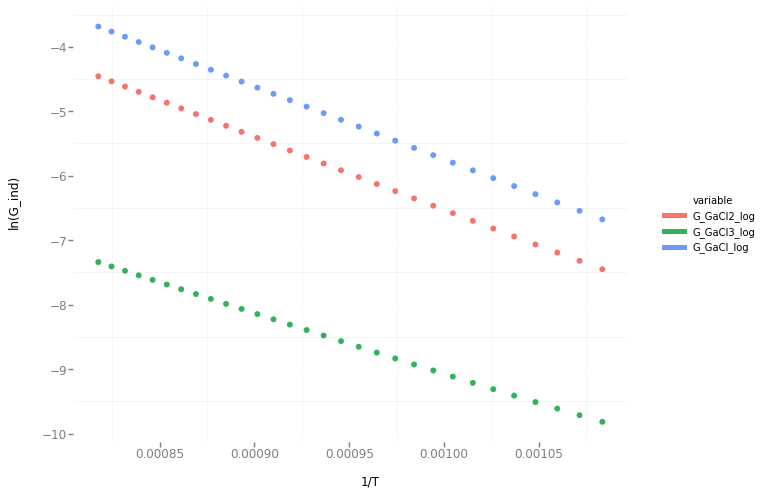

<ggplot: (320886849)>

In [15]:
(ggplot(aes(x = 'invT', y = 'value', color='variable'), graph_data_comp) + 
    geom_point(size=35) + 
    ylab('ln(G_ind)') + 
    xlab('1/T') + 
    theme_bw()
)

На графике выше представлены диаграммы Аррениуса для G<sub>GaCl</sub>, G<sub>GaCl2</sub>, G<sub>GaCl3</sub>

Из этого можно делать вывод, что преобладающим Ga-содержащим компонентом является GaCl.
Также установим зависимость скорости испарения источника галлия V<sup>e</sup><sub>Ga</sub> в зависимости от 1/T.

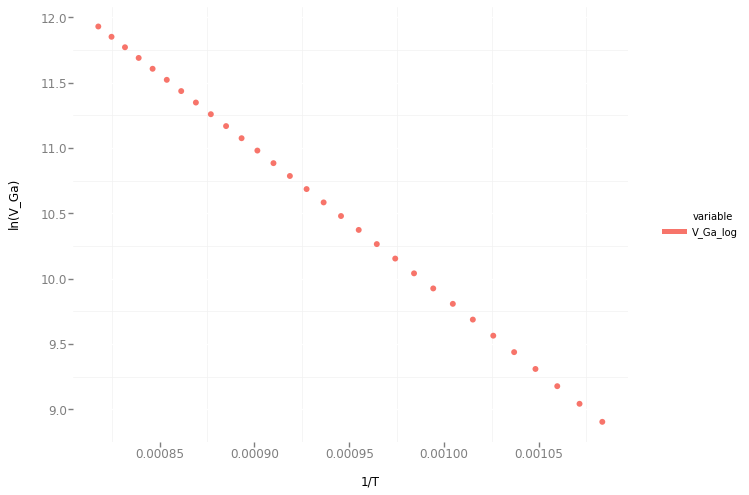

<ggplot: (321032297)>

In [16]:
(ggplot(aes(x = 'invT', y = 'value', color='variable'), graph_data_speed) + 
    geom_point(size=35) + 
    ylab('ln(V_Ga)') + 
    xlab('1/T') + 
    theme_bw()
)

# Задание №3

**Система:**


P<sup>e</sup><sub>AlCl3</sub>P<sup>e</sup><sub>NH3</sub> - K<sub>9</sub> x(P<sup>e</sup><sub>HCl</sub>)<sup>3</sup> = 0

P<sup>e</sup><sub>GaCl</sub>P<sup>e</sup><sub>NH3</sub> - K<sub>10</sub>(1 - x)P<sup>e</sup><sub>HCl</sub>P<sup>e</sup><sub>H2</sub> = 0

D<sub>HCl</sub>(P<sup>g</sup><sub>HCl</sub> - P<sup>e</sup><sub>HCl</sub>) +
2D<sub>H2</sub>(P<sup>g</sup><sub>H2</sub> - P<sup>e</sup><sub>H2</sub>) +
3D<sub>NH3</sub>(P<sup>g</sup><sub>NH3</sub> - P<sup>e</sup><sub>NH3</sub>) = 0

3D<sub>AlCl3</sub>(P<sup>g</sup><sub>AlCl3</sub> - P<sup>e</sup><sub>AlCl3</sub>) +
D<sub>GaCl</sub>(P<sup>g</sup><sub>GaCl</sub> - P<sup>e</sup><sub>GaCl</sub>) +
D<sub>HCl</sub>(P<sup>g</sup><sub>HCl</sub> - P<sup>e</sup><sub>HCl</sub>) = 0

D<sub>AlCl3</sub>(P<sup>g</sup><sub>AlCl3</sub> - P<sup>e</sup><sub>AlCl3</sub>) +
D<sub>GaCl</sub>(P<sup>g</sup><sub>GaCl</sub> - P<sup>e</sup><sub>GaCl</sub>) +
D<sub>NH3</sub>(P<sup>g</sup><sub>NH3</sub> - P<sup>e</sup><sub>NH3</sub>) = 0

D<sub>AlCl3</sub>(P<sup>g</sup><sub>AlCl3</sub> - P<sup>e</sup><sub>AlCl3</sub>)(1 - x) -
D<sub>GaCl</sub>(P<sup>g</sup><sub>GaCl</sub> - P<sup>e</sup><sub>GaCl</sub>)x = 0

На каждом шаге для величин $x_g = 0\dots1$ с шагом 0.0(3) и температуры $T = 1100℃$ производится решение данной СНУ, 

Такое решение даёт требуемые термодинамические давления, а с помощью формулы

$G_i = D_i \cdot (P^g_{i} - P^e_{i}) / RT\delta$

находятся межфазные потоки активных компонент. Далее по формуле

$ V^g_{AlGaN} = (G_{AlCl3} (\mu_{AlN} / \rho_{AlN}) + G_{GaCl} (\mu_{GaN} / \rho_{GaN})) * 10^9$

находится скорость роста слоя алгана.

In [17]:
'''
x_g:[0, 1]
n2Percentage: [0, 1]
    1 and 0.9 by task
'''
def system3(x_g, T, n2Percentage):
    assert (0 <= x_g <= 1), "x_g should be in [0, 1] range"
    assert (0 <= n2Percentage <= 1), "n2Percentage should be in [0, 1] range"
    
    p_e_AlCl3, p_e_GaCl, p_e_NH3, p_e_HCl, p_e_H2, x = sm.symbols('p_e_AlCl3, p_e_GaCl, p_e_NH3, p_e_HCl, p_e_H2, x')
    pg_AlCl3_GaCl = 30
    pg_N2_H2 = 98470
    pg_NH3 = 1500
    pg_HCl = 0
    pg_N2 = pg_N2_H2 * n2Percentage
    pg_H2 = pg_N2_H2 - pg_N2
    pg_AlCl3 = x_g * pg_AlCl3_GaCl
    pg_GaCl = pg_AlCl3_GaCl - pg_AlCl3
    d_HCl = d('HCl', T, P_a)
    d_H2 = d('H2', T, P_a)
    d_NH3 = d('NH3', T, P_a)
    d_AlCl3 = d('AlCl3', T, P_a)
    d_GaCl = d('GaCl', T, P_a)
    
    equations = []
    equations.append(p_e_AlCl3 * p_e_NH3 - k9(T) * x * p_e_HCl ** 3)
    equations.append(p_e_GaCl * p_e_NH3 - k10(T) * (1 - x) * p_e_HCl * p_e_H2)
    equations.append(d_HCl * (pg_HCl - p_e_HCl) + 2 * d_H2 * (pg_H2 - p_e_H2) + 3 * d_NH3 * (pg_NH3 - p_e_NH3))
    equations.append(3 * d_AlCl3 * (pg_AlCl3 - p_e_AlCl3) + d_GaCl * (pg_GaCl - p_e_GaCl) + d_HCl * (pg_HCl - p_e_HCl))
    equations.append(d_AlCl3 * (pg_AlCl3 - p_e_AlCl3) + d_GaCl * (pg_GaCl - p_e_GaCl) - d_NH3 * (pg_NH3 - p_e_NH3))
    equations.append(d_AlCl3 * (pg_AlCl3 - p_e_AlCl3) * (1 - x) - d_GaCl  * (pg_GaCl  - p_e_GaCl)  * x)
    system = sm.Matrix(equations)
    return system, (p_e_AlCl3, p_e_GaCl, p_e_NH3, p_e_HCl, p_e_H2, x)

**Решение задачи моделирование роста твердого раствора algan (AlxGa1-xN)**

До этого мы узнали, что  AlCl3 и GaCl являются преобладающими  компонентами растущего алгана. Исходя из этого, мы понимаем из-за каких "производящих" реакция в основном происходит рост алгана (это позволяет нам построить систему уравнений выше). Решение разбиваем на две части:
несущий газ – чистый N2 и несущий газ – 10%-ая смесь H2 и N2. Моделирование совершается при температуре 1100 градусов по Цельсию. Перебираем x_g (P_g_AlCl3 / (P_g_AlCl3 + P_g_GaCl)) в промежутке от 0 до 1. Для каждого значение составляем систему и решаем её выше описанным методом. Получив значение термодинамических давлений, мы высчитываем межфазные потоки (G), а затем и скорость роста слоя V<sub>AlGaN</sub>, а также построить диаграмму вхождения аллюминия в кристал. Значения всех констант взяты из условия. В качестве начального приближения на первом шаге мы берем набор состоящий из элементов равномерного распредления от 0 до 1 необходимой длинны, а на последующих итерациях в качестве начального приближения используем сошедшееся решение системы прошлого шага.

In [18]:
x_gs = np.linspace(0., 1., 30)
n2Percentages = [1, 0.9]
T = 1100 + 273
pg_AlCl3_GaCl = 30
data_for_temperature = pd.DataFrame(columns=['x_g', 'n2Percentage', 'x', 'V_AlGaN', 'G_GaCl', 'G_AlCl3'])
targets = ['GaCl', 'AlCl3']
initX = np.random.uniform(0.1, 1., 6).tolist()
for k, (x_g, n2Percentage) in (enumerate(product(x_gs, n2Percentages))):
    x = 2
    firstIter = True
    while x < 0 or x > 1:
        if firstIter == False:
            initX = np.random.uniform(0.1, 1., 6).tolist()
        
        firstIter = False
        system, variables = system3(x_g, T, n2Percentage)
        solution = newton_method(initX, system,variables)
        x = solution[-1]
    # G for elements
    initX = solution
    G = {}
    pg['AlCl3'] = x_g * pg_AlCl3_GaCl
    pg['GaCl'] = (1 - x_g) * pg_AlCl3_GaCl
    pe = dict(zip(map(str, variables), solution))
    for gasIndex in targets:
        G[gasIndex] = d(gasIndex, T, P_a) * (pg[gasIndex] - pe['p_e_' + gasIndex]) / (8314 * T * delta)
    density_AlN = 3200.
    density_GaN = 6150.
    mu_AlN = elementsData['AlN']['mu']
    mu_GaN = elementsData['GaN']['mu']
    V = (G['AlCl3'] * (mu_AlN / density_AlN) + G['GaCl'] * (mu_GaN / density_GaN)) * 1e9
    if V <= 1e5:
        data_for_temperature.loc[k] = {
            'x_g': x_g,
            'n2Percentage': n2Percentage,
            'x': pe['x'],
            'V_AlGaN': V,
            'G_GaCl': G['GaCl'],
            'G_AlCl3': G['AlCl3']
    }

--- 0.0617678165435791 seconds ---
--- 9 steps ---

--- 0.019919872283935547 seconds ---
--- 9 steps ---

--- 0.019390106201171875 seconds ---
--- 10 steps ---

--- 0.019296646118164062 seconds ---
--- 10 steps ---

--- 0.020157814025878906 seconds ---
--- 5 steps ---

--- 0.028315067291259766 seconds ---
--- 5 steps ---

--- 0.01951909065246582 seconds ---
--- 6 steps ---

--- 0.027025938034057617 seconds ---
--- 5 steps ---

--- 0.019368886947631836 seconds ---
--- 6 steps ---

--- 0.027685880661010742 seconds ---
--- 5 steps ---

--- 0.020990848541259766 seconds ---
--- 6 steps ---

--- 0.02947402000427246 seconds ---
--- 5 steps ---

--- 0.019430160522460938 seconds ---
--- 6 steps ---

--- 0.026813745498657227 seconds ---
--- 5 steps ---

--- 0.019666194915771484 seconds ---
--- 6 steps ---

--- 0.03147697448730469 seconds ---
--- 5 steps ---

--- 0.01932072639465332 seconds ---
--- 6 steps ---

--- 0.028079986572265625 seconds ---
--- 6 steps ---

--- 0.02143096923828125 seconds 

Скорость роста слоя алгана, когда несущий газ - N2:

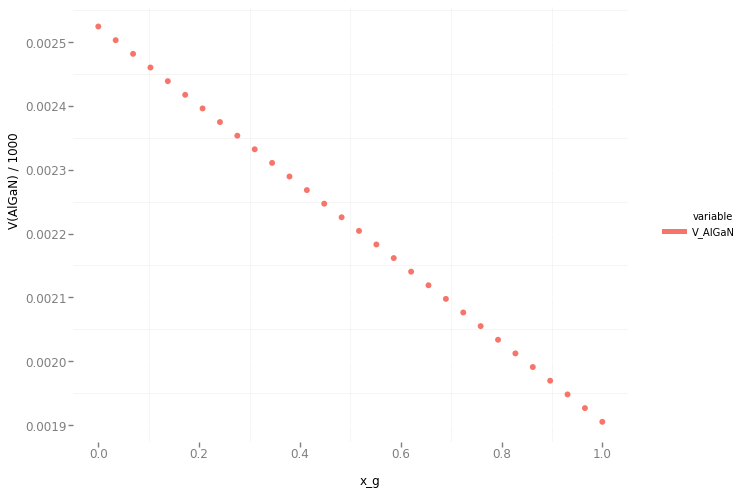

<ggplot: (321068121)>

In [19]:
data_for_temperature['V_AlGaN'] = data_for_temperature.V_AlGaN / 1000
graph_data_speed = pd.melt(data_for_temperature[['x_g', 'V_AlGaN', 'n2Percentage']], id_vars=['x_g', 'n2Percentage'])
(ggplot(aes(x = 'x_g', y = 'value', color='variable'), graph_data_speed[graph_data_speed.n2Percentage == 1]) + 
    geom_point(size=35) + 
    ylab('V(AlGaN) / 1000') +
    theme_bw()
)

Скорость роста слоя алгана, когда несущий газ - смесь N2 и H2:

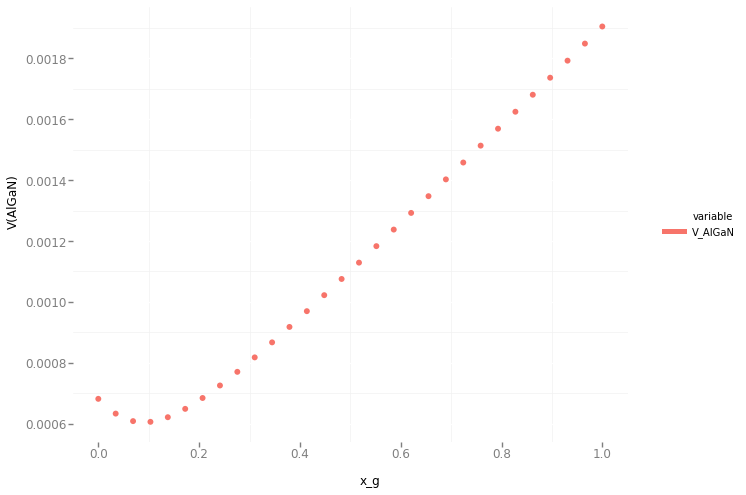

<ggplot: (321068089)>

In [20]:
(ggplot(aes(x = 'x_g', y = 'value', color='variable'), graph_data_speed[graph_data_speed.n2Percentage == 0.9]) + 
    geom_point(size=35) + 
    ylab('V(AlGaN)') +
    theme_bw()
)

График вхождения Al в кристалл при различных несущих газах:

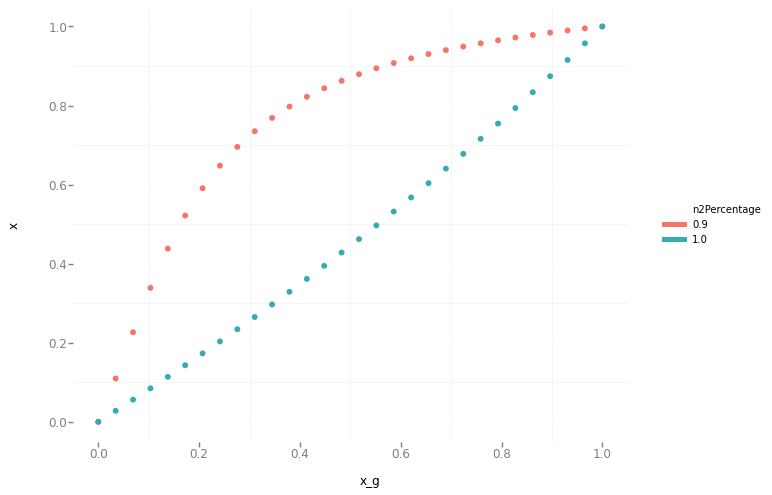

<ggplot: (321193373)>

In [21]:
graph_data_fraction = pd.melt(data_for_temperature, id_vars=['x_g', 'n2Percentage'])
graph_data_fraction.n2Percentage = graph_data_fraction.n2Percentage.map(str)
(ggplot(aes(y='value', x='x_g', color='n2Percentage'), data=graph_data_fraction[graph_data_fraction.variable == 'x']) +
     geom_point(size=35) +
     ylab('x') +
     xlab('x_g') +
     theme_bw()
)

Если несущим газом является чистый N2, диаграмма вхождения Al в кристалл близка к линейной, однако в случае, если несущий газ представляет собой 10% смесь H2 и N2, то диаграмма представляет собой выпуклую линию.
Сравнивая результаты вычислений с экспериментальными данными из работы [1], видно, что диаграмма вхождения Al при смеси в качестве несущего газа менее выпукла, чем экспериментальная.

Чтобы понять эффект от добавления H<sub>2</sub>, вспомним химические реакции (R7) и (R8).

Равновесное парциальное давления H<sub>2</sub> не влияет на химическую реакцию AlCl + NH<sub>3</sub> ⬄ AlN(solid) + HCl + H<sub>2</sub>, из-за этого межфазовый поток AlCl<sub>3</sub> не меняется на графиках.

В свою очередь, на реакцию 2AlCl<sub>2</sub> + 2NH<sub>3</sub> ⬄ 2AlN(solid) + 4HCl + H<sub>2</sub> оказывается влияение от этого давления, в результате чего небольшое количество H<sub>2</sub> резко снижает межфазовый поток GaCl. Если добавить больше H<sub>2</sub>, то реакция вовсе остановится и Ga перестанет оседать на алган.

Вспомним также химические реакции (R9) и (R10):

AlCl3 + NH3 <=> AlN(solid) + 3HCl
GaCl + NH3 <=> GaN(solid) + HCl + H2
	 	 	
При добавлении небольшого количества H2 реакция образования GaN замедлится, ведь она находится в химическом равновесии(протекает как слева направо, так и наоборот), и при увеличении H2 система будет пытаться уравновесить реакцию, что приведет к изменению состава. На реакцию с Al добавление H2 влияние не оказывает.

Получается, что, благодаря контролированию количества добавленного H<sub>2</sub> в несущий азот, мы можем регулировать состав алгана с необходимой точностью